In [18]:
import numpy as np
import scipy as sp
import sympy
import math
import matplotlib.pyplot as plt
from heart import heart
from valve_p import ValveinP
from three_windkessel import PressureSystem
from three_windkessel import lumped_resection_unified

In [26]:
## T=0.8
lv=heart(tau1 = 0.269*T, tau2 = 0.452*T, # tau1,2 (s)
         m1 = 1.32, m2 = 27.4, # m1,2
         Emax = 3,Emin = 0.08, # Emax,min (mmHg/mL)
        V0 = 10,T = T)# V0 (mL), T (s)

la=heart(tau1 = 0.110*T, tau2 = 0.180*T, #tau1,2
         m1 = 1.32,m2 = 13.1, # m1,2
         Emax = 0.17, Emin = 0.08, #Emax,min(mmHg/mL)
         V0 = 3,T = T) # V0 (mL), T (s)

av=ValveinP(density = 1.06, eff_length = 2.2,Aann = 5, # density, eff_length(cm), Aann
            Kvo = 0.12,Kvc = 0.15, # Kvo,Kvc
            p_oc = 0) #poc

mv=ValveinP(density = 1.06,eff_length =1.9,Aann = 5, # density, eff_length(cm), Aann
            Kvo = 0.3,Kvc = 0.4, # Kvo,Kvc
            p_oc = 0) #poc

#cap_s=PressureSystem(0.0008, 90, 700)#C,Za,R
cap_s=PressureSystem(0.0008, 90, 1200)

rv=heart(0.269*T,0.452*T, # tau1, 2
         1.32,27.4, # m1,2
         0.6,0.04, #Emax, min
         10,T) # Ks, V0 ,T

ra=heart(0.110*T,0.180*T, # tau1, 2
         1.32,13.1, # m1,2
         0.15,0.04, # Emax,min
         3, T) # Ks, V0, T

tv=ValveinP(1.06,2,6, # density, eff_length, Aann(cm2)
            0.3,0.4, # Kvo,Kvc
            0) #poc (mmHg)

pv=ValveinP(1.06,1.9,2.8, # density, eff_length, Aann(cm2)
            0.2,0.2, # Kvo,Kvc
            0) #poc

#cap_p=PressureSystem(0.0017, 10, 71.25)#C,Za,R
t_end=15
t = [0,t_end]
t_step = 0.01
t_span=np.arange(0,t_end,t_step)
index_range = slice(1320, 1400)
aeff_av_values = []
et_lv = []
p_lv_values=[]
time=[]
def dydt(t,y):
    v_lv = y[0]
    v_la = y[1]
    q_av = y[2]
    q_mv = y[3]
    xi_av = y[4]
    xi_mv = y[5]
    #pressure of capillaries in systemic circulation
    pa = y[6]
    v_rv = y[7]
    v_ra = y[8]
    q_tv = y[9]
    q_pv = y[10]
    xi_tv = y[11]
    xi_pv = y[12]
    #pressure of capillaries in pulmonary circulation
    pb = y[13]
    
    #calculate parameters
    #systemic
    p_la = la.p(v_la,t,0.85*T)
    p_lv = lv.p(v_lv,t)
    #p_aa: pressure at the coupling point of av and capillaries
    p_aa = cap_s.pi(q_av,pa)
    #pulmonary
    p_ra = ra.p(v_ra,t,0.85*T)
    p_rv = rv.p(v_rv,t)
    #q_cap2: flow out the capillaries of pulmonary circulation
    q_cap2 = cap_p.qout(pb,p_la)
    #p_pa: pressure at the coupling point of pv and capillaries
    p_pa = cap_p.pi(q_tv,pb)
    #q_cap1: flow out the capillaries of systemic circulation
    q_cap1 = cap_s.qout(pa,p_ra)
    
    #derivative
    #la
    dv_la = la.dv(t,v_la,q_cap2,q_mv)
    dxi_mv = mv.dxi(t,xi_mv,p_la,p_lv)
    dq_mv = mv.dq(t,q_mv,xi_mv,p_la,p_lv)
    #lv
    dv_lv = lv.dv(t,v_lv,q_mv,q_av)
    dxi_av = av.dxi(t,xi_av,p_lv,p_aa)
    dq_av = av.dq(t,q_av,xi_av,p_lv,p_aa)
    #cap sys
    dpa = cap_s.dp_original(t,pa,q_av,p_ra)
    #ra
    dv_ra = ra.dv(t,v_ra,q_cap1,q_tv)
    dxi_tv = tv.dxi(t,xi_tv,p_ra,p_rv)
    dq_tv = tv.dq(t,q_tv,xi_tv,p_ra,p_rv)
    #rv
    dv_rv = rv.dv(t,v_rv,q_tv,q_pv)
    dxi_pv = pv.dxi(t,xi_pv,p_rv,p_pa)
    dq_pv = pv.dq(t,q_pv,xi_pv,p_rv,p_pa)
    #cap pul
    dpb = cap_p.dp_original(t,pb,q_pv,p_la)
    
    #derivative vector
    dy = np.array([dv_lv, dv_la, 
                   dq_av, dq_mv, 
                   dxi_av, dxi_mv, 
                   dpa, 
                   dv_rv, dv_ra, 
                   dq_tv, dq_pv, 
                   dxi_tv, dxi_pv, 
                   dpb])
    return dy

In [27]:
rvef_surgery = []
lvef_surgery = []
sv_rv_surgery = []
sv_lv_surgery = []
p_pa_surgery = []
p_rv_surgery = []
input_para = []
v_rv_surgery = []
v_ra_surgery = []
p_lv_surgery = []
v_lv_surgery = []
v_la_surgery = []
p_ao_surgery = []
q_av_list = []
q_pv_list = []
labels = []
input_para.append([12.5,142.5,0.00875])#healthy, Za, R, C
#input_para.append([0.0017, 25, 100])#healthy, Za, R, C
labels = ['healthy']


In [4]:
for n in np.arange(1,5):
    pul_cir = lumped_resection_unified(trunk_c = 0.001, trunk_r = 7.5, artery_r = 5, artery_c = 0.00075, arterioles_r = 10, arterioles_c = 0.005, capillaries_r = 120,  venules_r= 10, venules_c = 0.001, vein_r = 2.5, vein_c = 0.001, n = n, N =5)
    R = pul_cir.r4()
    Za = pul_cir.r3()
    C = pul_cir.c()
    input_para.append([Za, R, C])
    labels.append(' Resection:{} lobe(s)'.format(n))

In [28]:
for i in range(len(input_para)):
    cap_p=PressureSystem(input_para[i][2], input_para[i][0],input_para[i][1])#C,Za,R
    y_initial = np.array([160, 27, #lv, la
                      150, 10, #qav, qmv
                      0.01, 0.5, #xi_av, xi_mv
                      5*1333, #pa
                      180, 40, #v_rv, v_ra 
                      150, 10, #q_tv, q_pv
                      0.01, 0.5, #xi_tv, xi_pv
                      5*1333]) # pb
    #integration
    sol = sp.integrate.solve_ivp(dydt , t , y0 = y_initial , t_eval = t_span, method='LSODA')
    v_lv = sol.y[0]
    v_la = sol.y[1]
    q_av = sol.y[2]
    q_mv = sol.y[3]
    xi_av = sol.y[4]
    xi_mv = sol.y[5]
    pa = sol.y[6]
    v_rv = sol.y[7]
    v_ra = sol.y[8]
    q_tv = sol.y[9]
    q_pv = sol.y[10]
    xi_tv = sol.y[11]
    xi_pv = sol.y[12]
    pb = sol.y[13]
    p_pa = []
    p_ao = []
    p_rv = []
    p_lv = []
    for i,j in zip(sol.t,range(len(sol.t))):
        p_pa.append(cap_p.pi(q_pv[j],pb[j]))
        p_ao.append(cap_s.pi(q_av[j],pa[j]))
        p_rv.append(rv.p(v_rv[j],i))
        p_lv.append(lv.p(v_lv[j],i))
    max_rv = max(sol.y[7][index_range])
    min_rv = min(sol.y[7][index_range])
    max_lv = max(sol.y[0][index_range])
    min_lv = min(sol.y[0][index_range])
    v_ra_surgery.append(v_ra)
    v_rv_surgery.append(v_rv)
    sv_rv_surgery.append(max_rv-min_rv)
    sv_lv_surgery.append(max_lv-min_lv)
    rvef_surgery.append(sv_rv_surgery[-1]/max_rv)
    lvef_surgery.append(sv_lv_surgery[-1]/max_lv)
    p_pa_count = list(map(lambda x: x / 1333, p_pa))
    p_pa_surgery.append(p_pa_count)
    p_ao_count = list(map(lambda x: x / 1333, p_ao))
    p_ao_surgery.append(p_ao_count)
    p_rv_count = list(map(lambda x: x / 1333, p_rv))
    p_rv_surgery.append(p_rv_count)
    p_lv_count = list(map(lambda x: x / 1333, p_lv))
    p_lv_surgery.append(p_lv_count)
    v_la_surgery.append(v_la)
    v_lv_surgery.append(v_lv)
    q_av_list.append(q_av)
    q_pv_list.append(q_pv)

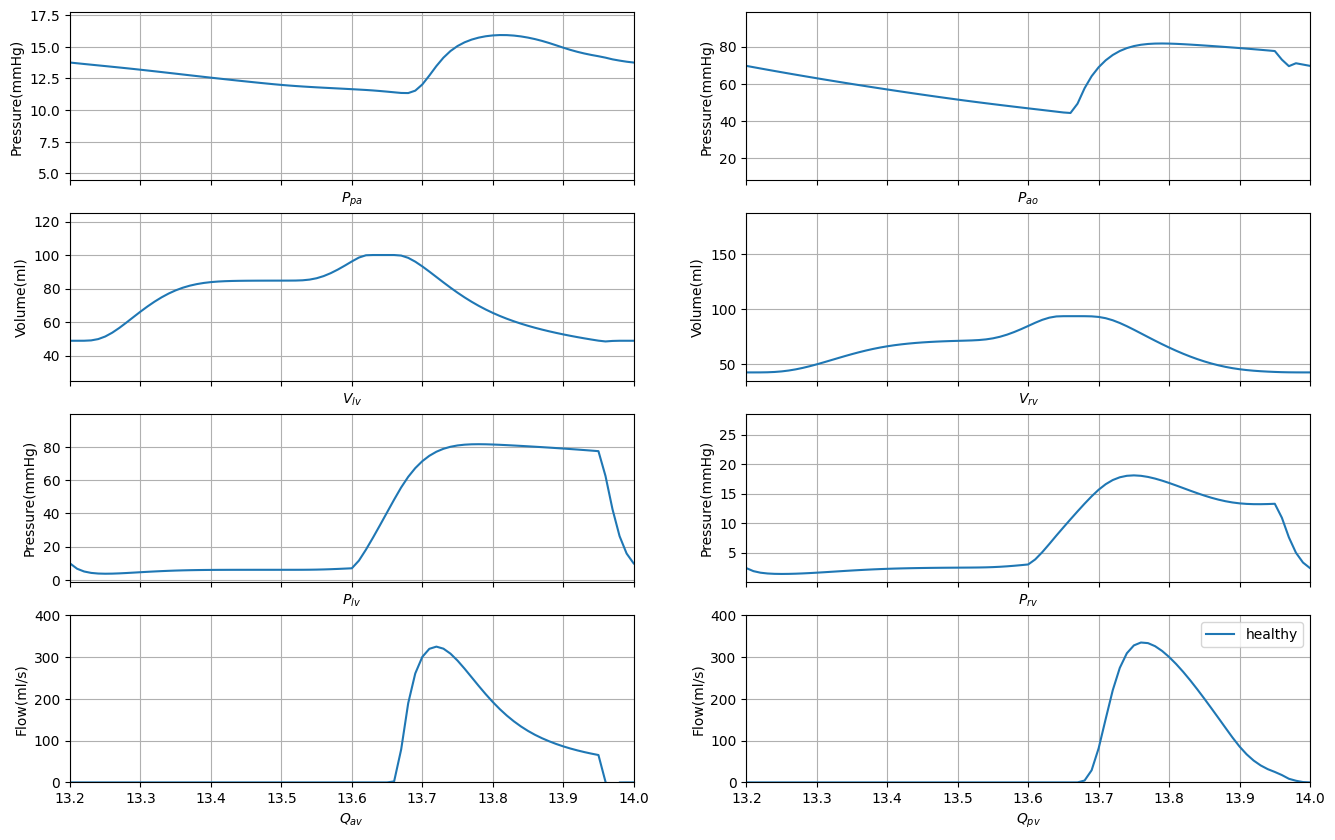

In [29]:
fig, ((ax1, ax2), (ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(4, 2, figsize=(16,10),sharex=True)
for i in range(len(p_pa_surgery)):
    ax1.plot(sol.t, p_pa_surgery[i],label =labels[i])
ax1.set_xlim(13.2,14)
ax1.set_ylabel('Pressure(mmHg)')
ax1.set_xlabel(r'$P_{pa}$')
ax1.grid()

for i in range(len(p_ao_surgery)):
    ax2.plot(sol.t, p_ao_surgery[i],label =labels[i])
ax2.set_xlim(13.2,14)
ax2.set_ylabel('Pressure(mmHg)')
ax2.set_xlabel(r'$P_{ao}$')
ax2.grid()

for i in range(len(p_pa_surgery)):
    ax3.plot(sol.t, v_lv_surgery[i],label =labels[i])
ax3.set_xlim(13.2,14)
ax3.set_ylim(25,125)
ax3.set_ylabel('Volume(ml)')
ax3.set_xlabel(r'$V_{lv}$')
ax3.grid()
for i in range(len(p_pa_surgery)):
    ax4.plot(sol.t, v_rv_surgery[i],label =labels[i])
ax4.set_xlim(13.2,14)
ax4.set_ylabel('Volume(ml)')
ax4.set_xlabel(r'$V_{rv}$')
ax4.grid()

for i in range(len(p_pa_surgery)):
    ax5.plot(sol.t, p_lv_surgery[i],label =labels[i])
ax5.set_xlim(13.2,14)
ax5.set_ylabel('Pressure(mmHg)')
ax5.set_xlabel(r'$P_{lv}$')
ax5.grid()
for i in range(len(p_pa_surgery)):
    ax6.plot(sol.t, p_rv_surgery[i],label =labels[i])
ax6.set_xlim(13.2,14)
ax6.set_ylabel('Pressure(mmHg)')
ax6.set_xlabel(r'$P_{rv}$')
ax6.grid()

for i in range(len(p_pa_surgery)):
    ax7.plot(sol.t, q_av_list[i],label =labels[i])
ax7.set_xlim(13.2,14)
ax7.set_ylim(0,400)
ax7.set_ylabel('Flow(ml/s)')
ax7.set_xlabel(r'$Q_{av}$')
ax7.grid()
for i in range(len(p_pa_surgery)):
    ax8.plot(sol.t, q_pv_list[i],label =labels[i])
ax8.set_xlim(13.2,14)
ax8.set_ylim(0,400)
ax8.set_ylabel('Flow(ml/s)')
ax8.set_xlabel(r'$Q_{pv}$')
ax8.grid()

plt.legend()
plt.savefig('resection_model_results.svg', format='svg')
plt.show()

In [30]:
print(sv_rv_surgery)
print(rvef_surgery)
print(lvef_surgery)
print(sv_lv_surgery)

[51.212439833714726]
[0.5484482672621002]
[0.5158907099708375]
[51.62427473654462]


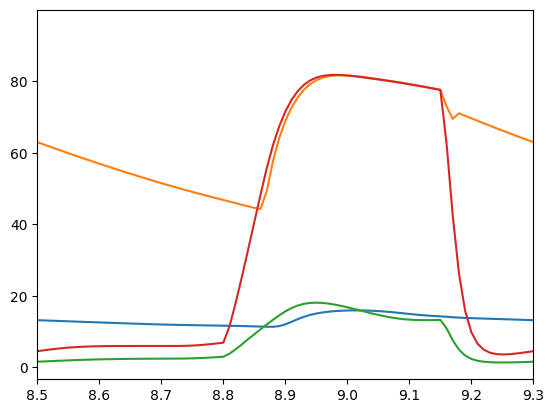

In [43]:
plt.plot(sol.t, p_pa_surgery[0])
plt.plot(sol.t, p_ao_surgery[0])
plt.plot(sol.t, p_rv_surgery[0])
plt.plot(sol.t, p_lv_surgery[0])
plt.xlim(8.5,9.3)
plt.show()

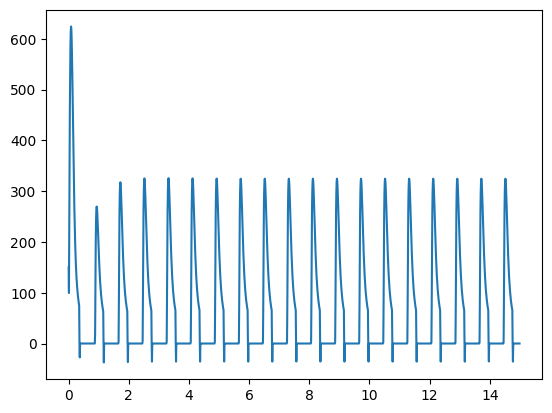

In [17]:
plt.plot(sol.t, q_av_list[0])
plt.show()

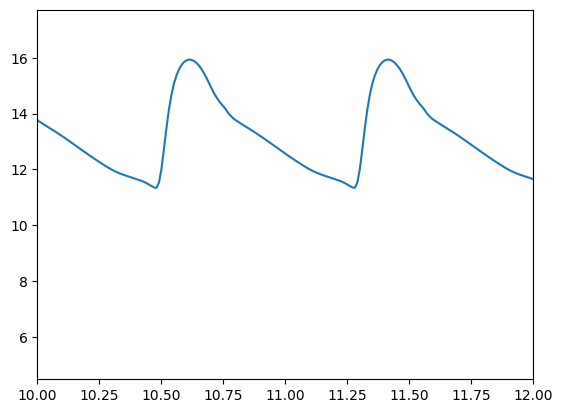

In [35]:
plt.plot(sol.t, p_pa_surgery[0])
plt.xlim(10,12)
plt.show()